In [ ]:
# ML Assignment
# Developing a comprehensive strategy for Bahubelly to optimize revenue, identify key menu items based on time trends, and forecast inventory needs for effective decision-making in Navi Mumbai.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor,GradientBoostingRegressor,BaggingRegressor

In [2]:
data=pd.read_csv(r"ML PROJECT.csv")

In [3]:
data.head()

,Order No.,Client OrderID,Order Type,Sub Order Type,Customer Name,Customer Phone,Customer Address,Items,My Amount,Total Discount,Delivery Charge,Container Charge,Total Tax,Round Off,Grand Total,Payment Type,Status,Created
0,50992,NaN,Dine In,Dine In,mohan,0.0,NaN,"Idli, Medu Vada (1 Piece)",75,0.0,0,0,3.76,0.24,79,Other [UPI],Printed,10/28/2024 13:09
1,50991,NaN,Dine In,Dine In,na,0.0,NaN,Water (500 Ml),20,0.0,0,0,0.00,0.00,20,Cash,Printed,10/28/2024 12:58
2,50990,1.890700e+14,Delivery,Bahubelly - Swiggy,Rhythm,NaN,NaN,"Idli (2 Pcs), Mysore Butter Masala Dosa",228,45.6,0,0,9.12,0.48,192,Online,Printed,10/28/2024 12:56
3,50989,NaN,Dine In,Dine In,na,0.0,NaN,Tea [1 Cup],30,0.0,0,0,0.00,0.00,30,Other [UPI],Printed,10/28/2024 12:55
4,50988,NaN,Dine In,Dine In,na,0.0,NaN,Water (500 Ml),10,0.0,0,0,0.00,0.00,10,Other [UPI],Printed,10/28/2024 12:51


Data Preprocessing

In [4]:
data.head()

,Order No.,Client OrderID,Order Type,Sub Order Type,Customer Name,Customer Phone,Customer Address,Items,My Amount,Total Discount,Delivery Charge,Container Charge,Total Tax,Round Off,Grand Total,Payment Type,Status,Created
0,50992,NaN,Dine In,Dine In,mohan,0.0,NaN,"Idli, Medu Vada (1 Piece)",75,0.0,0,0,3.76,0.24,79,Other [UPI],Printed,10/28/2024 13:09
1,50991,NaN,Dine In,Dine In,na,0.0,NaN,Water (500 Ml),20,0.0,0,0,0.00,0.00,20,Cash,Printed,10/28/2024 12:58
2,50990,1.890700e+14,Delivery,Bahubelly - Swiggy,Rhythm,NaN,NaN,"Idli (2 Pcs), Mysore Butter Masala Dosa",228,45.6,0,0,9.12,0.48,192,Online,Printed,10/28/2024 12:56
3,50989,NaN,Dine In,Dine In,na,0.0,NaN,Tea [1 Cup],30,0.0,0,0,0.00,0.00,30,Other [UPI],Printed,10/28/2024 12:55
4,50988,NaN,Dine In,Dine In,na,0.0,NaN,Water (500 Ml),10,0.0,0,0,0.00,0.00,10,Other [UPI],Printed,10/28/2024 12:51


In [5]:
#drop irrelevant columns
data = data.drop(columns=['Client OrderID', 'Customer Name', 'Customer Phone', 'Customer Address', 'Status'])

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9942 entries, 0 to 9941
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Order No.         9942 non-null   int64  
 1   Order Type        9942 non-null   object 
 2   Sub Order Type    9942 non-null   object 
 3   Items             9942 non-null   object 
 4   My Amount         9942 non-null   int64  
 5   Total Discount    9942 non-null   float64
 6   Delivery Charge   9942 non-null   int64  
 7   Container Charge  9942 non-null   int64  
 8   Total Tax         9942 non-null   float64
 9   Round Off         9942 non-null   float64
 10  Grand Total       9942 non-null   int64  
 11  Payment Type      9942 non-null   object 
 12  Created           9942 non-null   object 
dtypes: float64(3), int64(5), object(5)
memory usage: 1009.9+ KB


In [7]:
#Checking Null Values
data.isnull().sum()

Order No.           0
Order Type          0
Sub Order Type      0
Items               0
My Amount           0
Total Discount      0
Delivery Charge     0
Container Charge    0
Total Tax           0
Round Off           0
Grand Total         0
Payment Type        0
Created             0
dtype: int64

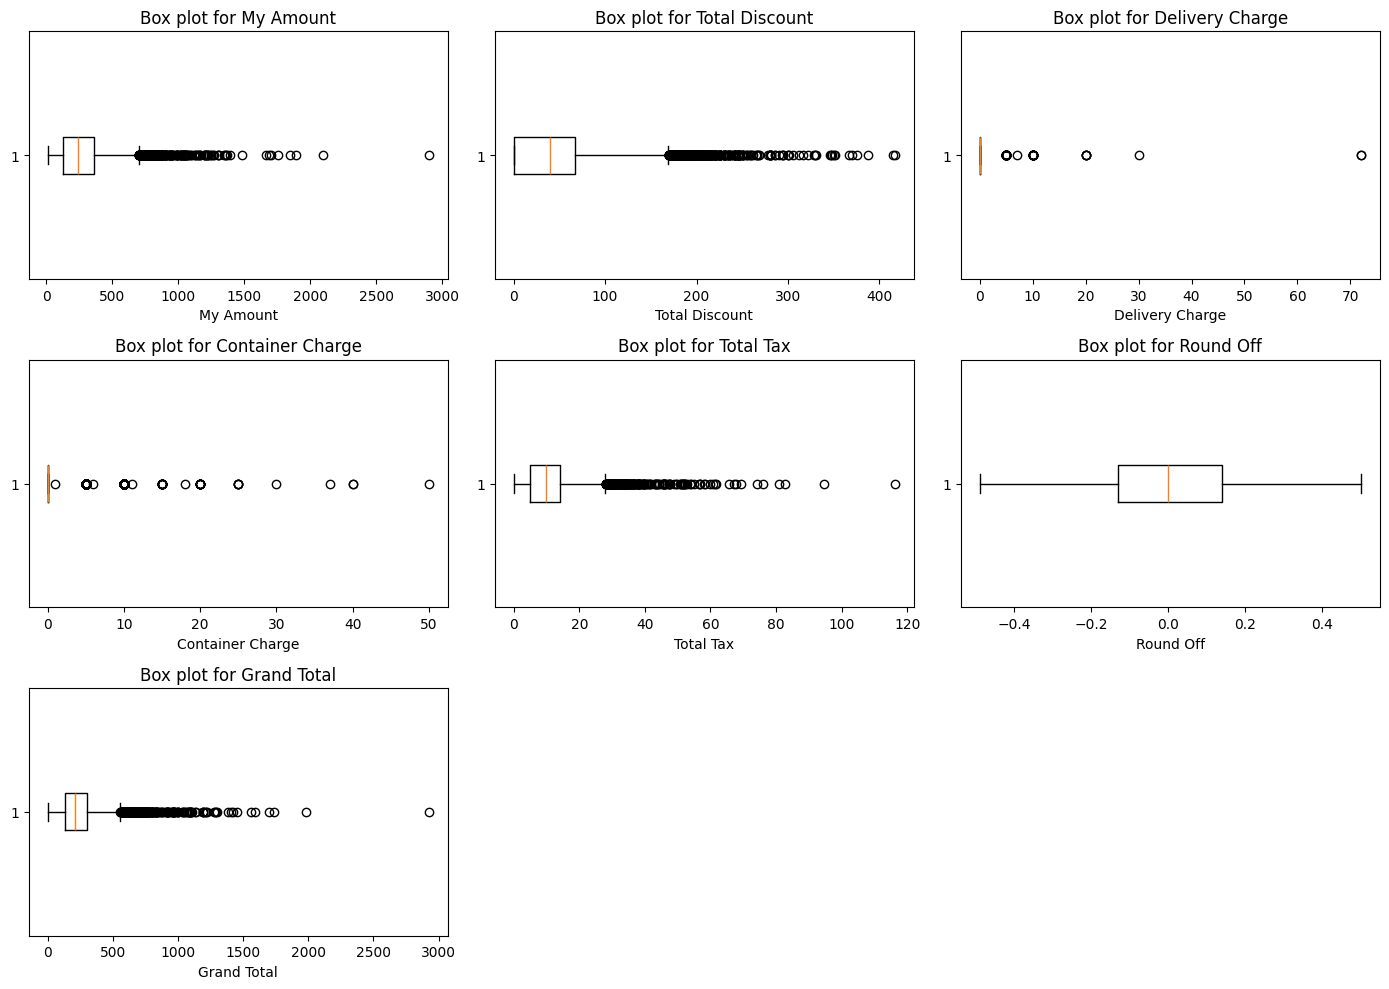

In [8]:
numerical_cols=['My Amount','Total Discount','Delivery Charge','Container Charge','Total Tax','Round Off','Grand Total']

plt.figure(figsize=(14, 10))

for i, col in enumerate(numerical_cols, 1):
    plt.subplot(3, 3, i)
    plt.boxplot(data[col], vert=False)
    plt.title(f'Box plot for {col}')
    plt.xlabel(col)

plt.tight_layout()
plt.show()

In [9]:
def treat_outliers_iqr(data,columns):
    for column in columns:
        Q1=data[column].quantile(0.25)
        Q3=data[column].quantile(0.75)
        IQR=Q3-Q1
        lower_bound=Q1-1.5*IQR
        upper_bound=Q3+1.5*IQR
        #capping outlier
        data[column]=data[column].apply(lambda x: lower_bound if x< lower_bound else upper_bound if x>upper_bound else x)
    return data

# Columns to treat for outliers
outlier_columns=['My Amount','Total Discount','Delivery Charge','Container Charge','Total Tax','Grand Total']

#Apply the function
data_cleaned=treat_outliers_iqr(data,outlier_columns)

#check the result
data_cleaned.describe()
        

,Order No.,My Amount,Total Discount,Delivery Charge,Container Charge,Total Tax,Round Off,Grand Total
count,9942.000000,9942.000000,9942.000000,9942.0,9942.0,9942.000000,9942.000000,9942.000000
mean,46021.500000,259.078254,45.024230,0.0,0.0,10.047051,0.021485,222.015691
std,2870.152522,169.048899,50.461638,0.0,0.0,6.920462,0.262935,132.977574
min,41051.000000,10.000000,0.000000,0.0,0.0,0.000000,-0.490000,0.000000
25%,43536.250000,130.000000,0.000000,0.0,0.0,4.960000,-0.130000,131.000000
50%,46021.500000,237.000000,39.800000,0.0,0.0,9.900000,0.000000,208.000000
75%,48506.750000,358.000000,67.600000,0.0,0.0,14.160000,0.140000,301.000000
max,50992.000000,700.000000,169.000000,0.0,0.0,27.960000,0.500000,556.000000


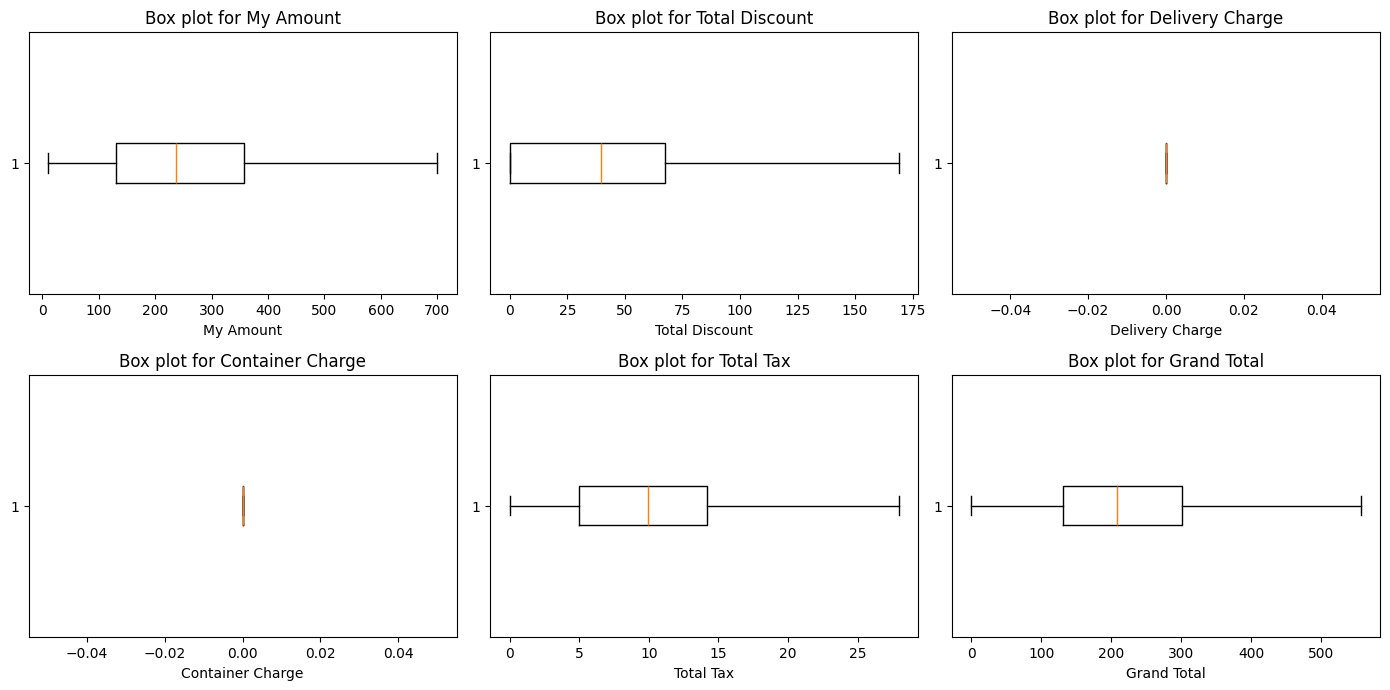

In [10]:
numerical_cols=['My Amount','Total Discount','Delivery Charge','Container Charge','Total Tax','Grand Total']

plt.figure(figsize=(14,10))

for i, col in enumerate(numerical_cols,1):
    plt.subplot(3,3,i)
    plt.boxplot(data[col],vert=False)
    plt.title(f'Box plot for {col}')
    plt.xlabel(col)
    
plt.tight_layout()
plt.show()

In [11]:
data.shape

(9942, 13)

In [12]:
#Convert the 'Created' column to datetime format and extract  time-based features
data['Created']=pd.to_datetime(data['Created'])
data['day']=data['Created'].dt.day
data['month']=data['Created'].dt.month
data['hour']=data['Created'].dt.hour
data['minute']=data['Created'].dt.minute
data['weekday']=data['Created'].dt.weekday

In [13]:
data.tail()

,Order No.,Order Type,Sub Order Type,Items,My Amount,Total Discount,Delivery Charge,Container Charge,Total Tax,Round Off,Grand Total,Payment Type,Created,day,month,hour,minute,weekday
9937,41055,Delivery,Zomato,"Idli & Vada (2+2), Set Uttapam (3 Pcs)",307.0,61.4,0.0,0.0,12.28,0.12,258.0,Online,2024-07-14 11:15:00,14,7,11,15,6
9938,41054,Delivery,Zomato,"Ghee Pineapple Sheera (250 Ml), Idli (4 Pcs)",224.0,44.8,0.0,0.0,8.96,-0.16,188.0,Online,2024-07-14 11:10:00,14,7,11,10,6
9939,41053,Delivery,Zomato,"Idli (4 Pcs), Medu Vada (2 Pcs)",204.0,40.8,0.0,0.0,8.16,-0.36,171.0,Online,2024-07-14 11:05:00,14,7,11,5,6
9940,41052,Delivery,Bahubelly - Swiggy,"Butter Masala Dosa, Dahi Vada (2 Pcs), Dal Vad...",700.0,70.5,0.0,0.0,27.96,-0.22,556.0,Online,2024-07-14 11:03:00,14,7,11,3,6
9941,41051,Delivery,Zomato,"Dal Vada (2 Pcs), Ghee Podi Masala Dosa, Medu ...",377.0,0.0,0.0,0.0,18.86,0.14,396.0,Online,2024-07-14 10:59:00,14,7,10,59,6


In [14]:
data.head()

,Order No.,Order Type,Sub Order Type,Items,My Amount,Total Discount,Delivery Charge,Container Charge,Total Tax,Round Off,Grand Total,Payment Type,Created,day,month,hour,minute,weekday
0,50992,Dine In,Dine In,"Idli, Medu Vada (1 Piece)",75.0,0.0,0.0,0.0,3.76,0.24,79.0,Other [UPI],2024-10-28 13:09:00,28,10,13,9,0
1,50991,Dine In,Dine In,Water (500 Ml),20.0,0.0,0.0,0.0,0.00,0.00,20.0,Cash,2024-10-28 12:58:00,28,10,12,58,0
2,50990,Delivery,Bahubelly - Swiggy,"Idli (2 Pcs), Mysore Butter Masala Dosa",228.0,45.6,0.0,0.0,9.12,0.48,192.0,Online,2024-10-28 12:56:00,28,10,12,56,0
3,50989,Dine In,Dine In,Tea [1 Cup],30.0,0.0,0.0,0.0,0.00,0.00,30.0,Other [UPI],2024-10-28 12:55:00,28,10,12,55,0
4,50988,Dine In,Dine In,Water (500 Ml),10.0,0.0,0.0,0.0,0.00,0.00,10.0,Other [UPI],2024-10-28 12:51:00,28,10,12,51,0


EDA

In [15]:
data["Grand Total"].describe()

count    9942.000000
mean      222.015691
std       132.977574
min         0.000000
25%       131.000000
50%       208.000000
75%       301.000000
max       556.000000
Name: Grand Total, dtype: float64

In [16]:
# Categorical Data Distribution
categorical_summary = {
    "Order Type": data["Order Type"].value_counts(),
    "Sub Order Type": data["Sub Order Type"].value_counts(),
    "Payment Type": data["Payment Type"].value_counts(),
}
for key, value in categorical_summary.items():
    print(f"\n{key} Distribution:\n", value)


Order Type Distribution:
 Order Type
Delivery    6960
Dine In     1822
Parcel      1160
Name: count, dtype: int64

Sub Order Type Distribution:
 Sub Order Type
Bahubelly - Swiggy               3499
Zomato                           3357
Dine In                          1816
Parcel                           1166
Medu Vada Factory - Swiggy         35
Bahubelly - Magicpin               28
Bahubelly - Thrive                 16
FusionDosa & Company - Zomato      16
Medu Vada Factory - Zomato          9
Name: count, dtype: int64

Payment Type Distribution:
 Payment Type
Online          6960
Other [UPI]     1738
Cash            1163
Part Payment      64
Due Payment       17
Name: count, dtype: int64


In [17]:
# Group by Month to find trends over time
monthly_trends = data.groupby('month')['Grand Total'].sum()
print("Monthly Sales Trend:\n", monthly_trends)

Monthly Sales Trend:
 month
7     321674.0
8     682510.0
9     662181.0
10    540915.0
Name: Grand Total, dtype: float64


In [18]:
# Group by Weekday to find trends over time
weekday_trends = data.groupby('weekday')['Grand Total'].sum()
print("Weekday Sales Trend:\n", weekday_trends)

Weekday Sales Trend:
 weekday
0    234496.0
1    234151.0
2    246725.0
3    263776.0
4    275710.0
5    424682.0
6    527740.0
Name: Grand Total, dtype: float64


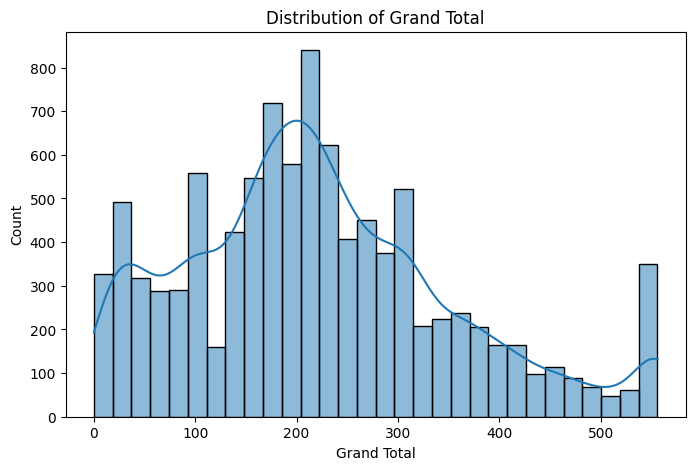

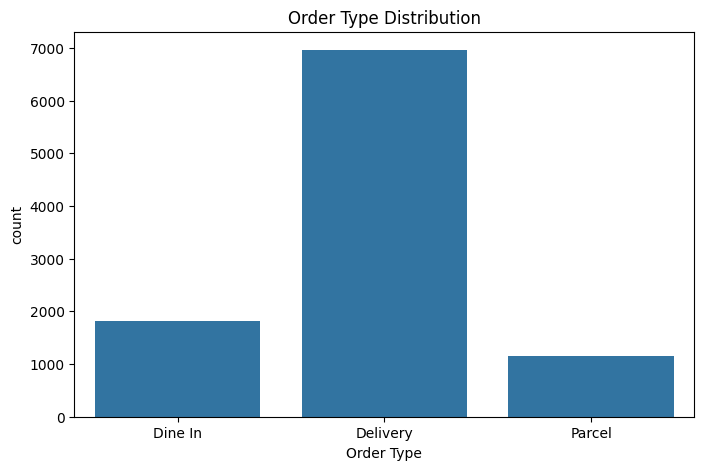

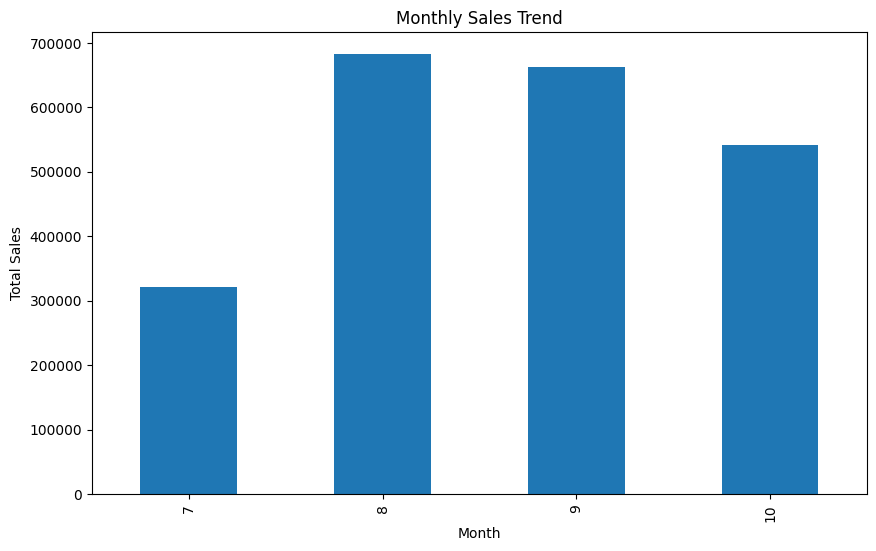

In [19]:
# Distribution of  'Grand Total'
plt.figure(figsize=(8, 5))
sns.histplot(data['Grand Total'], bins=30, kde=True)
plt.title("Distribution of Grand Total")
plt.xlabel('Grand Total')
plt.show()

# Order Type Distribution
plt.figure(figsize=(8, 5))
sns.countplot(data=data, x='Order Type')
plt.title('Order Type Distribution')
plt.show()

# Monthly Sales Trend
plt.figure(figsize=(10, 6))
monthly_trends.plot(kind='bar')
plt.title('Monthly Sales Trend')
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.show()

Word Cloud

One Hot Encoding

In [20]:
from wordcloud import WordCloud # pip install wordcloud # pip install wheel

In [21]:
#Combine all itmes into a single string for word cloud generation
text = ' '.join(data['Items'].dropna().astype(str))

# Customize the word cloud to emphasize frequnecy
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    colormap='viridis',
    max_words=100,
    scale=3,
    prefer_horizontal=1,
    min_font_size=10,
    max_font_size=100
).generate(text)

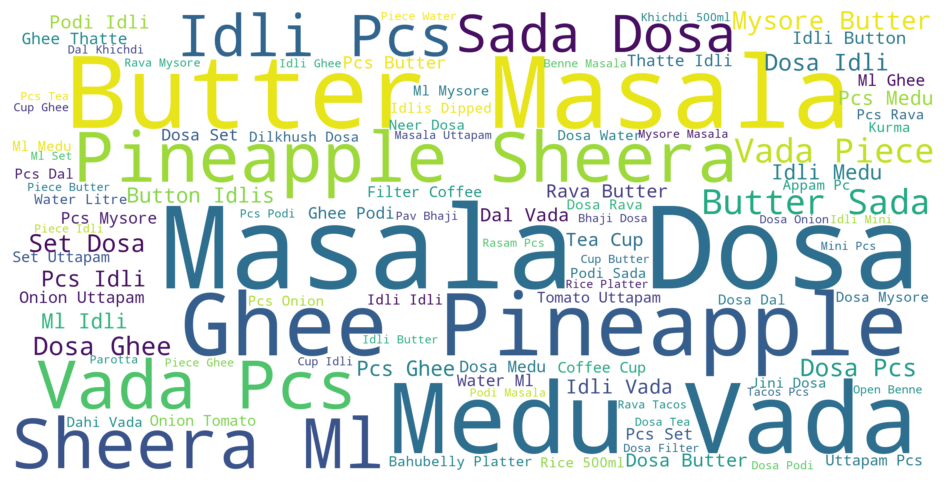

In [22]:
# Display the word cloud
plt.figure(figsize=(12,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [23]:
Quantitative_Variable=data.select_dtypes(include=[np.number])
Quantitative_Variable.head(3)

,Order No.,My Amount,Total Discount,Delivery Charge,Container Charge,Total Tax,Round Off,Grand Total,day,month,hour,minute,weekday
0,50992,75.0,0.0,0.0,0.0,3.76,0.24,79.0,28,10,13,9,0
1,50991,20.0,0.0,0.0,0.0,0.00,0.00,20.0,28,10,12,58,0
2,50990,228.0,45.6,0.0,0.0,9.12,0.48,192.0,28,10,12,56,0


In [24]:
Qualitative_Variable=data.select_dtypes(include=['object'])
Qualitative_Variable.head()

,Order Type,Sub Order Type,Items,Payment Type
0,Dine In,Dine In,"Idli, Medu Vada (1 Piece)",Other [UPI]
1,Dine In,Dine In,Water (500 Ml),Cash
2,Delivery,Bahubelly - Swiggy,"Idli (2 Pcs), Mysore Butter Masala Dosa",Online
3,Dine In,Dine In,Tea [1 Cup],Other [UPI]
4,Dine In,Dine In,Water (500 Ml),Other [UPI]


In [25]:
from sklearn.preprocessing import LabelEncoder
Qualitative_Variable=Qualitative_Variable.apply(LabelEncoder().fit_transform)
Qualitative_Variable.head(3)

,Order Type,Sub Order Type,Items,Payment Type
0,1,3,2644,3
1,1,3,3101,0
2,0,1,2500,2


In [26]:
Final_combined=pd.concat([Quantitative_Variable,Qualitative_Variable],axis=1)
Final_combined.head()

,Order No.,My Amount,Total Discount,Delivery Charge,Container Charge,Total Tax,Round Off,Grand Total,day,month,hour,minute,weekday,Order Type,Sub Order Type,Items,Payment Type
0,50992,75.0,0.0,0.0,0.0,3.76,0.24,79.0,28,10,13,9,0,1,3,2644,3
1,50991,20.0,0.0,0.0,0.0,0.00,0.00,20.0,28,10,12,58,0,1,3,3101,0
2,50990,228.0,45.6,0.0,0.0,9.12,0.48,192.0,28,10,12,56,0,0,1,2500,2
3,50989,30.0,0.0,0.0,0.0,0.00,0.00,30.0,28,10,12,55,0,1,3,3089,3
4,50988,10.0,0.0,0.0,0.0,0.00,0.00,10.0,28,10,12,51,0,1,3,3101,3


In [27]:
#Drop irrelevant columns
Final_combined=Final_combined.drop(columns=['Items','Delivery Charge','Container Charge','Round Off'])

In [28]:
Final_combined.tail()

,Order No.,My Amount,Total Discount,Total Tax,Grand Total,day,month,hour,minute,weekday,Order Type,Sub Order Type,Payment Type
9937,41055,307.0,61.4,12.28,258.0,14,7,11,15,6,0,8,2
9938,41054,224.0,44.8,8.96,188.0,14,7,11,10,6,0,8,2
9939,41053,204.0,40.8,8.16,171.0,14,7,11,5,6,0,8,2
9940,41052,700.0,70.5,27.96,556.0,14,7,11,3,6,0,1,2
9941,41051,377.0,0.0,18.86,396.0,14,7,10,59,6,0,8,2


In [29]:
from sklearn.model_selection import train_test_split

X=Final_combined.drop('Grand Total',axis=1)
y=Final_combined['Grand Total']

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

In [30]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error,r2_score
lr_model=LinearRegression()
lr_model.fit(X_train,y_train)

LinearRegression()

In [31]:
np.round(lr_model.intercept_,3)

236.167

In [32]:
np.round(lr_model.coef_,4)

array([-1.16000e-02,  8.75000e-01, -8.48300e-01,  2.42210e+00,
        1.06700e+00,  3.33158e+01, -5.13000e-02,  2.02000e-02,
       -1.78600e-01,  2.33800e-01,  4.03600e-01, -8.52000e-01])

In [33]:
train=pd.concat([X_train,y_train],axis=1)
train.head()

,Order No.,My Amount,Total Discount,Total Tax,day,month,hour,minute,weekday,Order Type,Sub Order Type,Payment Type,Grand Total
715,50277,169.0,20.00,7.46,20,10,9,53,6,0,8,2,156.0
809,50183,258.0,49.99,10.40,19,10,13,27,5,0,1,2,218.0
6481,44511,60.0,0.00,3.00,21,8,7,48,2,2,7,3,68.0
7533,43459,70.0,0.00,0.00,11,8,9,25,6,2,7,0,75.0
6436,44556,287.0,57.40,11.48,21,8,13,17,2,0,8,2,241.0


In [34]:
train['fitted_value']=np.round(lr_model.predict(X_train),2)
train['Residual']=np.round(train['Grand Total']-train['fitted_value'],2)
train.head()

,Order No.,My Amount,Total Discount,Total Tax,day,month,hour,minute,weekday,Order Type,Sub Order Type,Payment Type,Grand Total,fitted_value,Residual
715,50277,169.0,20.00,7.46,20,10,9,53,6,0,8,2,156.0,159.40,-3.40
809,50183,258.0,49.99,10.40,19,10,13,27,5,0,1,2,218.0,215.60,2.40
6481,44511,60.0,0.00,3.00,21,8,7,48,2,2,7,3,68.0,71.22,-3.22
7533,43459,70.0,0.00,0.00,11,8,9,25,6,2,7,0,75.0,75.47,-0.47
6436,44556,287.0,57.40,11.48,21,8,13,17,2,0,8,2,241.0,241.02,-0.02


In [35]:
r2=r2_score(train['Grand Total'],train['fitted_value'])
print('R-squared score for model performance on train:',np.round(r2,2)*100)

R-squared score for model performance on train: 98.0


This high R-squared value indicates that the model explains nearly all the variance iin the target (Grand Total) for both training and test sets. It suggests that the model is well fitted and captures the key drivers of Grand total, making it reliable for prediction.

In [36]:
lr_model.predict(X_train)
lr_score=r2_score(y_train,lr_model.predict(X_train))
lr_score

0.9845844987299521

In [37]:
lr_model.predict(X_test)
lr_score=r2_score(y_test,lr_model.predict(X_test))
lr_score

0.9901161694027917

In [38]:
model_mse=mean_squared_error(train['Grand Total'],train['fitted_value'])
model_rmse=np.sqrt(model_mse)

print("RMSE of Train Data : ",np.round(model_rmse,2))

RMSE of Train Data :  16.46


With a relatively low RMSE, the model's predictions are close to the actual values. This indicates the model can predict the final amounts accurately, helping the business  forecast revenues with high precision

In [39]:
#pick a different model and test which is better
Random_forest = RandomForestRegressor()
Ride_reg = Ridge()
XGBoost = XGBRegressor()
Random_forest = RandomForestRegressor()
Ada_boost = AdaBoostRegressor()
Grad_boost = GradientBoostingRegressor()
Bagging = BaggingRegressor()


In [40]:
model_li = [Ada_boost]
#model_li = [Ride_reg, Random_forest, Ada_boost, Grad_boost, Bagging]

In [41]:
Score = []
for model in model_li:
    model.fit(X_train,y_train)
    Score.append(r2_score(y_test,model.predict(X_test)))

In [42]:
#Score.append(lr_score)

In [43]:
Score

[0.97090496853298]

Adaboost also performs well, achieving a high R-squared score. This performance highlights Adaboost's potential to capture complex relationships between Grand Total and input features. Adaboost can be beneficial if the business seeks an ensemble approach to improve accuracy further

In [44]:
from sklearn.tree import DecisionTreeRegressor 
#Initialize and train the decision tree model
dt_model = DecisionTreeRegressor(max_depth=5, random_state=42)
dt_model.fit(X_train, y_train)

#Make predictions on test set
y_pred = dt_model.predict(X_test)

#calculate RMSE and R2  score
rmse = np.sqrt(mean_squared_error(y_test,y_pred))
r2 = r2_score(y_test, y_pred)

#print results
print(f"Decision Tree RMSE: {rmse: .4f}, R2 Score: {r2: .4f}")

Decision Tree RMSE:  13.6617, R2 Score:  0.9897


The Decision tree model has a slightly lower RMSE compared to Linear regression, indicating that it handles the data's variance well and may have captured non linear relationships. With a high R-squared, the decision tree model performs reliably for Grand Total prediction.

C:\Users\Omkar\AppData\Local\Temp\ipykernel_11792\64344701.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(y=imp.head().index, x=imp.head().values, palette="BrBG")


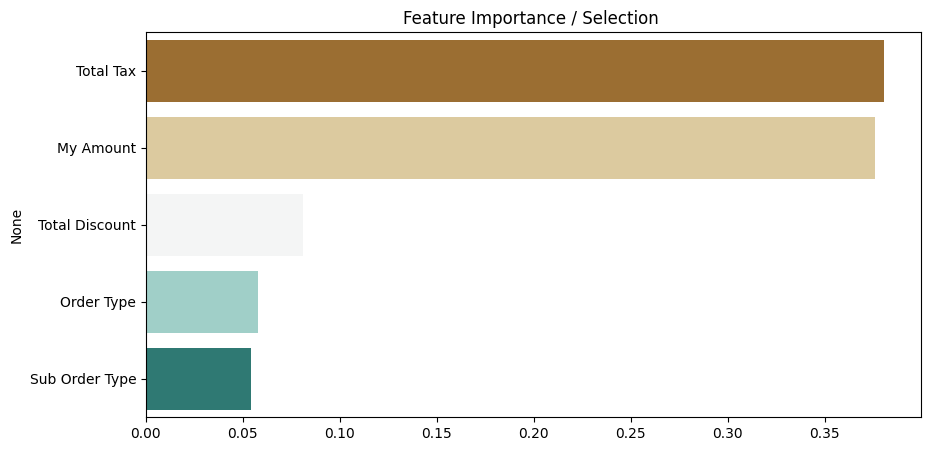

In [45]:
from sklearn.ensemble import RandomForestRegressor #y = Number
from sklearn.ensemble import RandomForestClassifier #y = category

#by default 100 tree will be formed
RFModel = RandomForestClassifier(random_state=20,
                                 n_estimators=25, #make 25 trees
                                 criterion= "gini",
                                 max_depth=4, #each tree will have 4 branches
                                 min_samples_split=100, #each tree will have parent node
                                 min_samples_leaf=50, #each tree will have child node
                                 max_features="sqrt") #variables selection in each tree
RFModel.fit(X_train, y_train)
imp = pd.Series(data=RFModel.feature_importances_, index=RFModel.feature_names_in_).sort_values(ascending=False)
plt.figure(figsize=(10,5))
plt.title("Feature Importance / Selection ")
ax = sns.barplot(y=imp.head().index, x=imp.head().values, palette="BrBG")


Important Features Interpretation
1. Total tax : Significant for estimating Grand Total, highlighting how taxes impact the final amount. Understanding this effect can guide tax-related adjustments or promotional pricing decisions
2. My Amount : Likely a primary factor in determining Grand Total, this feature could relate to the initial order value. Accurate predictions here can help optimize sales strategies.
3. Total Discount : Discount influences the final Sale amount, showing the direct impact of price adjustments. This insight can support discount related decisions by assessing which discount levels maximize profitability without heavily reducing Grand Total.
4. Order Type or sub order: These features suggest that different product or service categories(and sub categories) may yield different average Grand Total values. Understanding these distinctions helps the business prioritize high value categories and better tailor pricing strategies to each order type.

In [46]:
X_train.shape

(7953, 12)

Summary
Our model shows High predictive accuracy, supporting goals like revenue forecasting and strategic pricing adjustments. The importance of features such as tax, discount and order types provides actionable insights to improve pricing and discount strategies, which will help boost profitability and fulfill business objectives.

Model performance Interpretation according to our Business objectives 

1. Objective -Optimize Revenue Prediction:
   
   Model Performance - With a high R-squared on both Linear regression (98% on train, 99% on test) and Adaboost (97%), the model capture the variance      in Grand Total accurately
   Interpretation - High R-squared value indicates that the model can effectively predict revenue, making them valuable tools for accurate financial       forecasting. This allows our business to:
   Plan budgets more precisely
   Set Realistic revenue targets
   Allocate resources more effectively

2. Objective- Enhance Pricing strategies

   Model Performance - The low RMSE value across models(eg. Linear Regression:16.46, Decision tree:13.66)
   suggest minimal error in predicting Grand Total
   Interpretation - Low RMSE indicates that the model can forecast final prices accurately after applying taxes, discount, and charges. This insight       can support dynamic pricing strategies where:
   Pricing can be optimized by adjusting discounts, charges based on predictions
   Business can test different discount strategies to see their impact on grand total without risking large profit losses
   Feature importance insights like : "Total tax" and "Tax discount", highlight how taxes and discounts affect grand total, offering precise data for      fine tuning prices

3. Objective - Seasonal and Temporal trend Analysis

    Model performance - The accuracy across all model allows us to trust the temporal feature impacts, like those derived from the created column(eg,       day, month)
    Interpretation - Since the model predicts high accuracy we can use them to identify seasonal or time based sales patterns:
    To Adjust promotions or inventory during peak times
    Forecast when certain products or services are higher in demand, informing scheduling and stock decisions.

4. Objective - Improving Customer Profitability

    Model performance - With R-squared values close to 1, the models effectively capture key factors impacting grand total, especially features like        order type and sub order type
    Interpretation - Accurate grand total predictions  allows our business to assess profitability across customer segments:
    Understanding which order types or sub order types yield higher totals can guide targeted marketing or upsell efforts
    identifying profitable customer types helps in managing discounts or premium services enhancing customer profitability without weakening margins
   
   
    
   

      

CONCLUSION
The models accuracy enables revenue forecasting, pricing flexibility, seasonal trend identification, and customer segmentation, all of which drive operational decisions and profit

In [47]:
# Load data into a DataFrame
df = pd.read_csv(r'Final_data.csv')

# Convert 'Created' column to datetime
df['Created'] = pd.to_datetime(df['Created'], format='%m/%d/%Y %H:%M')

# Extract hour or any other time-related feature
df['Hour'] = df['Created'].dt.hour

In [48]:
df.head()

,Order No.,Order Type,Sub Order Type,Customer Name,Customer Address,Items,Quantity,My Amount,Total Discount,Delivery Charge,Container Charge,Total Tax,Round Off,Grand Total,Payment Type,Status,Created,Hour
0,50992,Dine In,Dine In,mohan,NaN,Idli,1,75,0.0,0,0,3.76,0.24,79,Other [UPI],Printed,2024-10-28 13:09:00,13
1,50992,Dine In,Dine In,mohan,NaN,Medu Vada,1,75,0.0,0,0,3.76,0.24,79,Other [UPI],Printed,2024-10-28 13:09:00,13
2,50991,Dine In,Dine In,na,NaN,Water,1,20,0.0,0,0,0.00,0.00,20,Cash,Printed,2024-10-28 12:58:00,12
3,50990,Delivery,Bahubelly - Swiggy,Rhythm,NaN,Idli,2,228,45.6,0,0,9.12,0.48,192,Online,Printed,2024-10-28 12:56:00,12
4,50990,Delivery,Bahubelly - Swiggy,Rhythm,NaN,Mysore Butter Masala Dosa,1,228,45.6,0,0,9.12,0.48,192,Online,Printed,2024-10-28 12:56:00,12


In [49]:
# Sort by 'Hour' and 'Quantity' to identify the most popular items first
item_counts = df.sort_values(by=['Hour', 'Items', 'Quantity'], ascending=[True, True, False])

# Remove duplicate prices within each 'Hour' and 'Item' group by keeping the first occurrence
item_counts = item_counts.drop_duplicates(subset=['Hour', 'Items'], keep='first')

# Group by Hour and Items and sum the quantity
item_counts = item_counts.groupby(['Hour', 'Items']).agg({'Quantity': 'sum', 'Grand Total': 'first'}).reset_index()

# Sort and find the top items
item_counts = item_counts.sort_values(by=['Hour', 'Quantity'], ascending=[True, False])
suggestions = item_counts.groupby('Hour')['Items'].apply(lambda x: x.head(3))
print(suggestions.head(10))

Hour     
7     9        Button Idlis Dipped In Rasam
      10     Button Idlis Dipped In Sambhar
      37                          Medu Vada
8     77       Button Idlis Dipped In Rasam
      78     Button Idlis Dipped In Sambhar
      112                         Medu Vada
9     164      Button Idlis Dipped In Rasam
      165    Button Idlis Dipped In Sambhar
      198                         Medu Vada
10    250      Button Idlis Dipped In Rasam
Name: Items, dtype: object


In [50]:
# Group by Hour and Items, and sum the quantity
item_counts = df.groupby(['Hour', 'Items'])['Quantity'].sum().reset_index()

# Sort by Hour and Quantity to find which items are most popular at specific times
item_counts = item_counts.sort_values(by=['Hour', 'Quantity'], ascending=[True, False])

In [51]:
# Suggest items to be kept ready based on the frequency
suggestions = item_counts.groupby('Hour')['Items'].apply(lambda x: x.head(3))  # Top 3 items for each hour
print(suggestions.head(10))

Hour     
7     27          Idli
      37     Medu Vada
      62      Set Dosa
8     101         Idli
      112    Medu Vada
      148     Set Dosa
9     188         Idli
      198    Medu Vada
      232     Set Dosa
10    271         Idli
Name: Items, dtype: object


C:\Users\Omkar\AppData\Local\Temp\ipykernel_11792\2984772135.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_items = item_counts.groupby('Hour').apply(lambda x: x.nlargest(5, 'Quantity')).reset_index(drop=True)


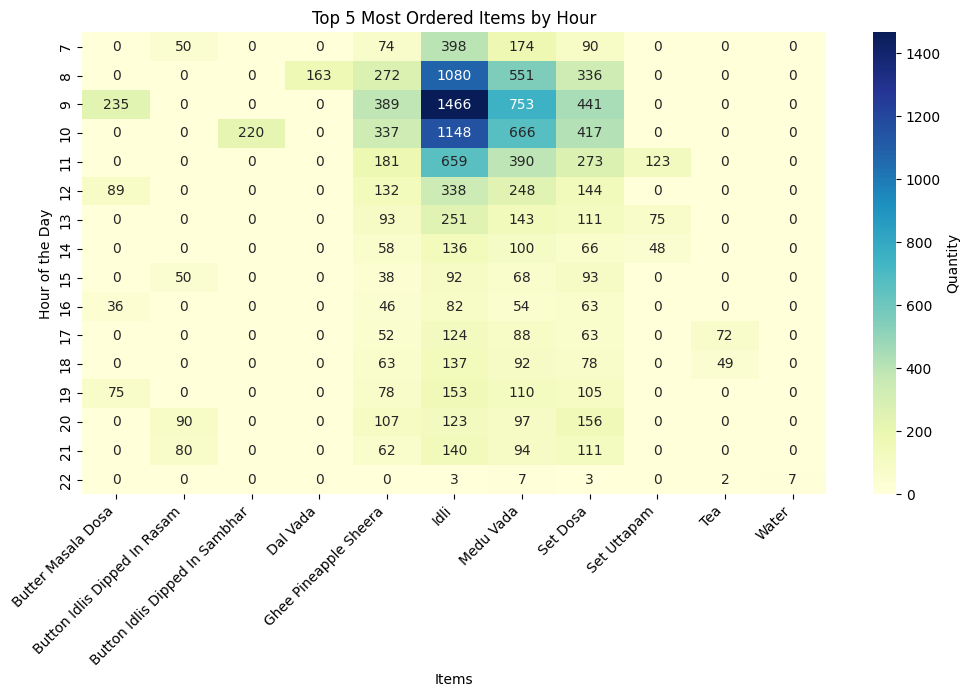

In [52]:
# Standardize the 'Items' column to avoid duplicate entries due to case or whitespace differences
item_counts['Items'] = item_counts['Items'].str.strip().str.title()

# Sum quantities for the same item within each hour to remove duplicates
item_counts = item_counts.groupby(['Hour', 'Items'], as_index=False)['Quantity'].sum()

# Get the top N items per hour, for example, top 5 items
top_items = item_counts.groupby('Hour').apply(lambda x: x.nlargest(5, 'Quantity')).reset_index(drop=True)

# Pivot the data
pivot_data = top_items.pivot(index='Hour', columns='Items', values='Quantity').fillna(0)

# Plot heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(pivot_data, cmap='YlGnBu', annot=True, fmt='.0f', cbar_kws={'label': 'Quantity'})
plt.title('Top 5 Most Ordered Items by Hour')
plt.xlabel('Items')
plt.ylabel('Hour of the Day')
plt.xticks(rotation=45, ha='right')
plt.show()

In [54]:
# Load dataset
data = pd.read_csv('Final_data.csv')

In [55]:
# Convert 'Created' column to datetime and set as index
data['Created'] = pd.to_datetime(data['Created'])
data.set_index('Created', inplace=True)

In [56]:
# Data preprocessing: aggregate by day and item
daily_data = data.groupby([data.index.date, 'Items'])['Quantity'].sum().unstack().fillna(0)
daily_data.index = pd.to_datetime(daily_data.index)  # Convert index back to datetime

In [57]:
# Feature Engineering: Add time-related features
daily_data['Day'] = daily_data.index.day
daily_data['Month'] = daily_data.index.month
daily_data['Year'] = daily_data.index.year
daily_data['DayOfWeek'] = daily_data.index.dayofweek

In [58]:
# Prepare target and features for model training
X = daily_data.drop(columns=daily_data.columns[:-4])  # Drop item columns, keeping time features
y = daily_data[daily_data.columns[:-4]]  # Target is all items (multi-target)

In [59]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [60]:
# Train a RandomForestRegressor for multi-target prediction
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [61]:
# Predict on test set
y_pred = model.predict(X_test)

In [62]:
# Convert predictions to a DataFrame for analysis
y_pred_df = pd.DataFrame(y_pred, index=y_test.index, columns=y_test.columns)

In [63]:
# Set a threshold for required inventory prediction
threshold = 1 

In [64]:
# Identify items that require inventory based on predictions
inventory_needs = {}
for item in y_test.columns:
    # Filter out dates and predicted quantities where inventory is required
    required_dates = y_pred_df[y_pred_df[item] >= threshold].index
    required_quantities = y_pred_df.loc[required_dates, item]
    if not required_quantities.empty:
        inventory_needs[item] = required_quantities

In [65]:
# Print items that need inventory and their predicted demand
print("Items Requiring Inventory Prediction:")
for item, demand in inventory_needs.items():
    print(f"\nItem: {item}")
    print(demand)

Items Requiring Inventory Prediction:

Item: Appam
2024-08-25    1.04
Name: Appam, dtype: float64

Item: Appam With Kurma
2024-09-28    3.76
2024-07-24    3.72
2024-07-18    1.92
2024-10-21    2.46
2024-09-22    4.80
2024-09-18    3.20
2024-08-13    1.60
2024-08-28    3.14
2024-10-16    1.66
2024-07-25    2.94
2024-09-30    2.34
2024-08-30    4.42
2024-07-14    3.78
2024-10-01    4.56
2024-08-01    3.20
2024-10-27    3.12
2024-09-07    3.72
2024-09-29    5.28
2024-09-17    3.60
2024-08-25    5.48
2024-07-26    2.68
2024-08-19    2.68
Name: Appam With Kurma, dtype: float64

Item: Bahubelly Fusion Combo
2024-10-01    1.47
Name: Bahubelly Fusion Combo, dtype: float64

Item: Bahubelly Platter
2024-09-28    3.15
2024-07-24    2.28
2024-07-18    4.15
2024-10-21    1.29
2024-09-22    3.28
2024-09-18    1.22
2024-08-13    4.54
2024-08-28    2.32
2024-07-25    3.32
2024-08-30    2.55
2024-07-14    5.58
2024-08-01    1.70
2024-10-27    3.33
2024-09-07    2.33
2024-09-29    4.69
2024-08-25    6.1

In [66]:
# Calculate overall R² Score for model performance
y_test_flat = y_test.values.ravel()
y_pred_flat = y_pred_df.values.ravel()
overall_r2 = r2_score(y_test_flat, y_pred_flat)
print(f"\nOverall R² Score for Model: {overall_r2}")


Overall R² Score for Model: 0.7785558858276083


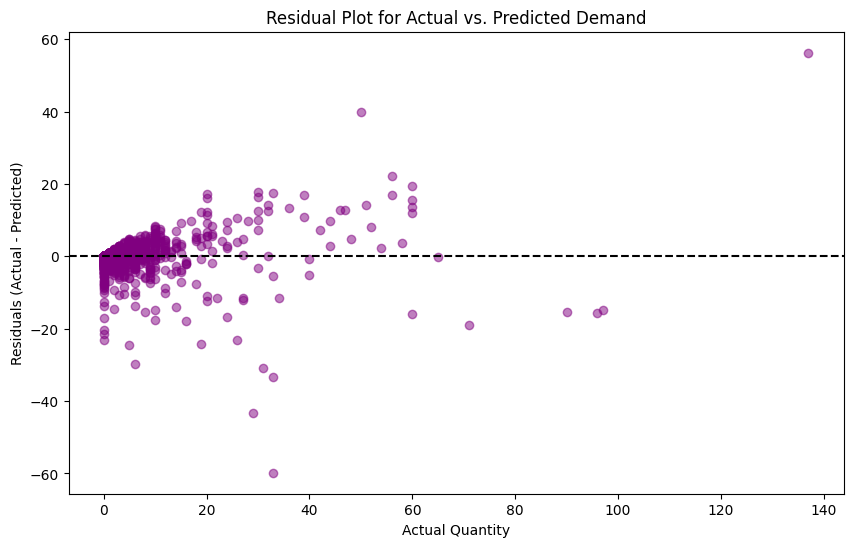

In [68]:
#Plot the actual vs. predicted demand for a specific item over time, 
#making it easier to see how well the model performs on individual item demand.
residuals = y_test_flat - y_pred_flat
plt.figure(figsize=(10, 6))
plt.scatter(y_test_flat, residuals, alpha=0.5, color='purple')
plt.axhline(0, color='black', linestyle='--')
plt.xlabel("Actual Quantity")
plt.ylabel("Residuals (Actual - Predicted)")
plt.title("Residual Plot for Actual vs. Predicted Demand")
plt.show()

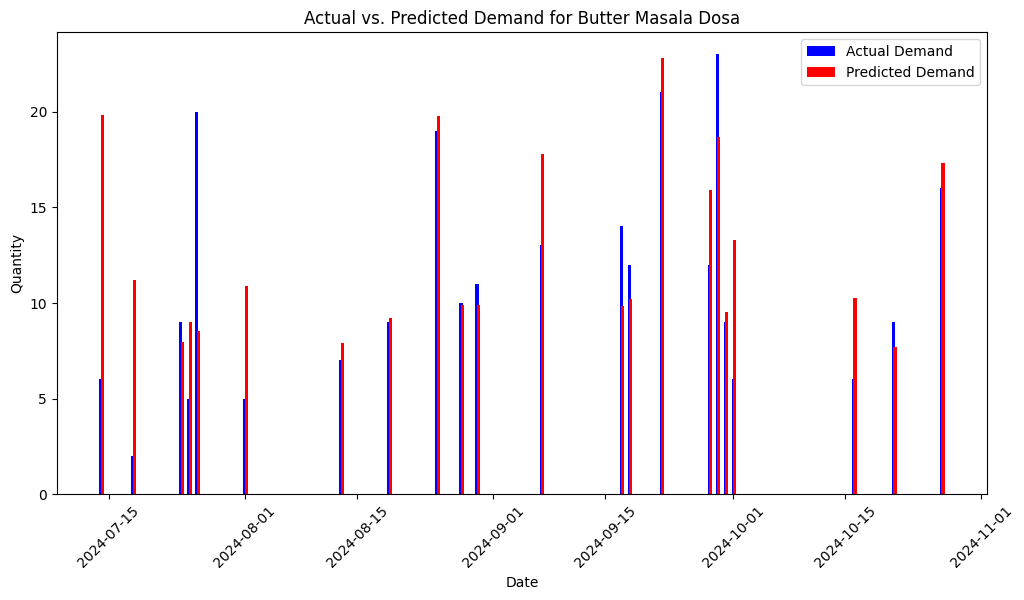

In [69]:
# Replace 'Item_Name' with the actual name of an item in your dataset
item = 'Butter Masala Dosa'  

plt.figure(figsize=(12, 6))

# Plot actual demand as blue bars
plt.bar(y_test.index, y_test[item], label='Actual Demand', color='blue', width=0.4, align='center')

# Plot predicted demand as red bars with a slight offset for visibility
plt.bar(y_test.index + pd.Timedelta(days=0.2), y_pred_df[item], label='Predicted Demand', color='red', width=0.4, align='center')

plt.xlabel("Date")
plt.ylabel("Quantity")
plt.title(f"Actual vs. Predicted Demand for {item}")
plt.legend()
plt.xticks(rotation=45)
plt.show()

# Inventory Prediction

We can identify the items that require inventory prediction based on their demand patterns over different dates. Here are some suggestions for spotting items that may need inventory planning:

High Demand on Specific Dates: If certain items consistently show high demand on specific dates or periods, these are candidates for inventory planning. For example:

Medu Vada has multiple dates with high quantities, indicating it's a popular item that may require careful inventory management.
Onion & Tomato Uttapam and Podi Idli also show high demand on certain dates, which suggests that they might need regular stock replenishment.
Seasonal Demand: Look for items with peaks during specific times (e.g., certain months or weekends) which may indicate seasonal or periodic demand. For example:

Onam Sadhya might see a spike in demand during the festival season, suggesting a need for increased inventory planning around that period.
Consistent Demand Over Time: Items with steady demand, like Masala Uttapam and Rava Butter Masala Dosa, will require a stable stock. Any forecast or prediction model should keep these consistently available based on historical data.

Low, Sporadic Demand: Some items like Pav Bhaji Dosa and Rava Masala Dosa appear less frequently or are in low demand on specific dates. Inventory prediction models might flag these as items with lower priority or less frequent restocking needs.

Unusual Peaks: Items with sporadic but high peaks (like Paneer Chilly Tacos on 2024-07-14) may need further analysis to determine if those peaks are anomalies or signals of future trends.

With these observations, inventory prediction models can focus on items with high and consistent demand, while deprioritizing low-demand or sporadic items. Further refining these insights can help guide inventory decisions and ensure popular items are always in stock.